# APPM 5720 Biweekly Report - Part 2/2
### *Alexey Yermakov*
### *October 27 2022*

# Summary
For this report my main goal was to train a smaller model through distillation. I used the Fashion MNIST dataset and a simple densely connected neural network to show the practical benefits of distillation. In part 1 , I used a multi-layer perceptron. In part 2 (this report), I use a convolutional neural network. I compare both models and have a discussion at the end of this report.

# Main Content

First I import everything I'll be using and make sure my GPU is running.

In [1]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import permute, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MaxNLocator

# Print matplotlibe plots inline
%matplotlib inline

# Check if GPU is available, though I don't use it in this notebook
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


Next, I create my convolutional neural network. I took inspiration from PyTorch's [AlexNet](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py) implementation. Here, I have 5 convolutions starting from 1 channel to 16 channels, with a bottleneck where I go to a max of 32 channels.

In [2]:
# Create our model
class NeuralNetwork(nn.Module):
    def __init__(self):
        # See https://realpython.com/python-super/
        super(NeuralNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
        )

        
        # Define labels
        self.labels = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
    def get_label(self, logits):
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        return y_pred

model1 = NeuralNetwork().to(device)

total_params = sum(p.numel() for p in model1.parameters())
print("Total Parameters:", total_params)

Total Parameters: 16758


Next, I load my dataset. I added the `preprocess` command so that the images and labels get loaded to my GPU automatically during training. I also use batch sizes of 32 just because it's easy and good for training.

In [3]:
# Download and load dataset
base_dir = "/home/alexey/Datasets/"
batch_size = 32

training_data = datasets.FashionMNIST(
    root=base_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=base_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

def preprocess(x, y):
    return x.to(device), y.to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            # *b makes it so that the input to func is two variables: the images and the labels
            # yield is like return except it stops execution until the object is "grabbed"
            yield (self.func(*b)) 

train_dl1 = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_dl1 = DataLoader(test_data, batch_size=batch_size, shuffle=False)
            
train_dl2 = WrappedDataLoader(train_dl1, preprocess)
test_dl2 = WrappedDataLoader(test_dl1, preprocess)

Next, I define the learning rate and epochs. These hyperparameters were chosen to balance training time and effectiveness of results. I didn't really try to get the model to be the "best", since I just wanted to show distilliation.

In [4]:
# Set hyperparameters
learning_rate = 1e-3
epochs = 50
# Make our optimizer
loss_fn1 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

Next, we define the training and testing loops. These have print statements in them so we can view progress during training.

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)*batch_size
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y = torch.nn.functional.one_hot(y, num_classes=10)
        y = y.to(torch.float32)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)*batch_size
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = torch.nn.functional.one_hot(y, num_classes=10)
            y = y.to(torch.float32)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == torch.argmax(y, dim=1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"correct: {100*correct}%")
    print(f"loss :{test_loss}%")
    return (100*correct, test_loss)

Now we can actually do some training! I'll save the running accuracy and loss so that I can plot them later.

In [6]:
train_acc1 = list()
test_acc1 = list()
train_loss1 = list()
test_loss1 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop(train_dl2, model1, loss_fn1, optimizer1)
    
    acc, loss = test_loop(train_dl2, model1, loss_fn1)
    train_acc1.append(acc)
    train_loss1.append(loss)
    
    acc, loss = test_loop(test_dl2, model1, loss_fn1)
    test_acc1.append(acc)
    test_loss1.append(loss)
print("Done!")

Epoch 1
---------------------------------
loss: 0.115332  [    0/60000]
loss: 0.089966  [ 3200/60000]
loss: 0.090406  [ 6400/60000]
loss: 0.082812  [ 9600/60000]
loss: 0.065522  [12800/60000]
loss: 0.064658  [16000/60000]
loss: 0.052139  [19200/60000]
loss: 0.046081  [22400/60000]
loss: 0.050013  [25600/60000]
loss: 0.053973  [28800/60000]
loss: 0.055975  [32000/60000]
loss: 0.038782  [35200/60000]
loss: 0.041171  [38400/60000]
loss: 0.058742  [41600/60000]
loss: 0.043272  [44800/60000]
loss: 0.054507  [48000/60000]
loss: 0.038096  [51200/60000]
loss: 0.039201  [54400/60000]
loss: 0.035639  [57600/60000]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.038784 

correct: 74.29166666666667%
loss :0.03878425683875879%
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.039308 

correct: 73.47244408945687%
loss :0.03930801841111991%
Epoch 2
---------------------------------
loss: 0.035686  [    0/60000]
loss: 0.038130  [ 3200/60000]
loss: 0.037208  [ 6400/60000]
loss: 0.045820  [ 9600/60000]
loss: 0.0348

loss: 0.021295  [ 3200/60000]
loss: 0.026409  [ 6400/60000]
loss: 0.028868  [ 9600/60000]
loss: 0.023756  [12800/60000]
loss: 0.031358  [16000/60000]
loss: 0.013885  [19200/60000]
loss: 0.015633  [22400/60000]
loss: 0.022703  [25600/60000]
loss: 0.032877  [28800/60000]
loss: 0.033985  [32000/60000]
loss: 0.017548  [35200/60000]
loss: 0.019868  [38400/60000]
loss: 0.030605  [41600/60000]
loss: 0.032321  [44800/60000]
loss: 0.032266  [48000/60000]
loss: 0.014286  [51200/60000]
loss: 0.028753  [54400/60000]
loss: 0.022390  [57600/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.023698 

correct: 84.255%
loss :0.023698391578470666%
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.024804 

correct: 83.33666134185303%
loss :0.02480438075804958%
Epoch 12
---------------------------------
loss: 0.021852  [    0/60000]
loss: 0.022131  [ 3200/60000]
loss: 0.026023  [ 6400/60000]
loss: 0.029646  [ 9600/60000]
loss: 0.023566  [12800/60000]
loss: 0.030692  [16000/60000]
loss: 0.013883  [19200/60000]
los

loss: 0.019784  [ 3200/60000]
loss: 0.025156  [ 6400/60000]
loss: 0.029520  [ 9600/60000]
loss: 0.023245  [12800/60000]
loss: 0.026110  [16000/60000]
loss: 0.014082  [19200/60000]
loss: 0.012968  [22400/60000]
loss: 0.019268  [25600/60000]
loss: 0.029374  [28800/60000]
loss: 0.028967  [32000/60000]
loss: 0.016139  [35200/60000]
loss: 0.018394  [38400/60000]
loss: 0.031759  [41600/60000]
loss: 0.030928  [44800/60000]
loss: 0.031873  [48000/60000]
loss: 0.013375  [51200/60000]
loss: 0.029037  [54400/60000]
loss: 0.022303  [57600/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.022574 

correct: 84.82166666666666%
loss :0.022573957624286413%
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.023910 

correct: 83.8158945686901%
loss :0.02391021266674843%
Epoch 22
---------------------------------
loss: 0.018386  [    0/60000]
loss: 0.019668  [ 3200/60000]
loss: 0.024977  [ 6400/60000]
loss: 0.029495  [ 9600/60000]
loss: 0.023870  [12800/60000]
loss: 0.026370  [16000/60000]
loss: 0.013880  [19200/

loss: 0.020090  [ 3200/60000]
loss: 0.023952  [ 6400/60000]
loss: 0.030372  [ 9600/60000]
loss: 0.022722  [12800/60000]
loss: 0.025393  [16000/60000]
loss: 0.016517  [19200/60000]
loss: 0.012312  [22400/60000]
loss: 0.019047  [25600/60000]
loss: 0.031684  [28800/60000]
loss: 0.029751  [32000/60000]
loss: 0.017305  [35200/60000]
loss: 0.018407  [38400/60000]
loss: 0.032028  [41600/60000]
loss: 0.032498  [44800/60000]
loss: 0.031930  [48000/60000]
loss: 0.011876  [51200/60000]
loss: 0.027334  [54400/60000]
loss: 0.020306  [57600/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.021340 

correct: 85.42333333333333%
loss :0.02134025736277302%
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.022877 

correct: 84.43490415335462%
loss :0.022876586842413147%
Epoch 32
---------------------------------
loss: 0.017053  [    0/60000]
loss: 0.019643  [ 3200/60000]
loss: 0.023763  [ 6400/60000]
loss: 0.030186  [ 9600/60000]
loss: 0.022678  [12800/60000]
loss: 0.025473  [16000/60000]
loss: 0.016144  [19200

loss: 0.019219  [ 3200/60000]
loss: 0.023784  [ 6400/60000]
loss: 0.031360  [ 9600/60000]
loss: 0.022619  [12800/60000]
loss: 0.025550  [16000/60000]
loss: 0.015819  [19200/60000]
loss: 0.011883  [22400/60000]
loss: 0.017377  [25600/60000]
loss: 0.028832  [28800/60000]
loss: 0.029287  [32000/60000]
loss: 0.017526  [35200/60000]
loss: 0.017884  [38400/60000]
loss: 0.032298  [41600/60000]
loss: 0.032618  [44800/60000]
loss: 0.028236  [48000/60000]
loss: 0.011675  [51200/60000]
loss: 0.026718  [54400/60000]
loss: 0.018312  [57600/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.020571 

correct: 85.73833333333334%
loss :0.020571377388139567%
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.022324 

correct: 84.47484025559106%
loss :0.022323866172458608%
Epoch 42
---------------------------------
loss: 0.016817  [    0/60000]
loss: 0.019464  [ 3200/60000]
loss: 0.023931  [ 6400/60000]
loss: 0.031721  [ 9600/60000]
loss: 0.022343  [12800/60000]
loss: 0.025885  [16000/60000]
loss: 0.016315  [1920

Now let's see how well the model did in a nice visual!

In [7]:
def plot_train_test_acc_loss(train_acc, test_acc, train_loss, test_loss, file_name = "PLOT"):
    '''
    plot_train_test_acc

    Make a plot of training vs testing accuracy
    '''
    # Print minimum
    if False:
        print()
        print(f"Max training accuracy was at epoch {np.argmax(train_acc)+1:>04} : {train_acc[np.argmax(train_acc)]}")
        print(f"Max testing accuracy was at epoch  {np.argmax(test_acc)+1:>04} : {test_acc[np.argmax(test_acc)]}")
        print()
        print(f"Min training loss was at epoch {np.argmin(train_loss)+1:>04} : {train_loss[np.argmin(train_loss)]}")
        print(f"Min testing loss was at epoch  {np.argmin(test_loss)+1:>04} : {test_loss[np.argmin(test_loss)]}")

    # Make plot
    fig, ax = plt.subplots(1,2,figsize=(10,5), dpi=120, facecolor='white', tight_layout={'pad': 1})

    marker_style = dict(markersize = 6)

    ax[0].plot(list(range(1, len(train_acc)+1)), train_acc, linestyle='solid', marker='^', color='#d95319', label="Training Accuracy", **marker_style)
    ax[0].plot(list(range(1, len(test_acc)+1)), test_acc, linestyle='solid', marker='^', color='#0072bd', label="Testing Accuracy", **marker_style)

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    ax[0].legend(fontsize='small')

    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(list(range(1, len(train_loss)+1)), train_loss, linestyle='solid', marker='^', color='#d95319', label="Training Loss", **marker_style)
    ax[1].plot(list(range(1, len(test_loss)+1)), test_loss, linestyle='solid', marker='^', color='#0072bd', label="Testing Loss", **marker_style)

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    ax[1].legend(fontsize='small')

    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


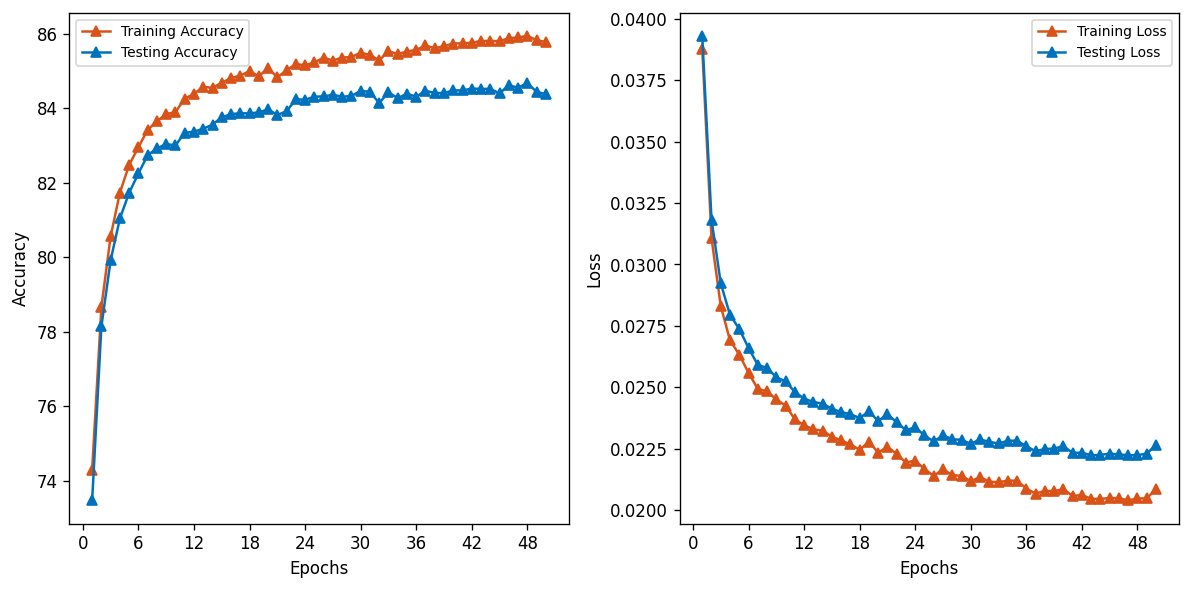

Max training accuracy: 85.94% at epoch 48
Max testing accuracy:  84.67% at epoch 48
Min training loss:     0.020391059402003885 at epoch 47
Min testing loss:      0.022229579866479953 at epoch 43


In [8]:
plot_train_test_acc_loss(train_acc1, test_acc1, train_loss1, test_loss1)
print(f"Max training accuracy: {max(train_acc1):2.2f}% at epoch {np.argmax(train_acc1)+1}")
print(f"Max testing accuracy:  {max(test_acc1):2.2f}% at epoch {np.argmax(test_acc1)+1}")
print(f"Min training loss:     {min(train_loss1)} at epoch {np.argmin(train_loss1)+1}")
print(f"Min testing loss:      {min(test_loss1)} at epoch {np.argmin(test_loss1)+1}")

Great! So our model works. Compared to our MLP, this model has much less overfitting. The training and testing loss/accuracy and much closer to each other, which is fantastic! This shows the power of convolutions on image datasets.

Let's see what kind of predictions our model makes:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2393/2473694711.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


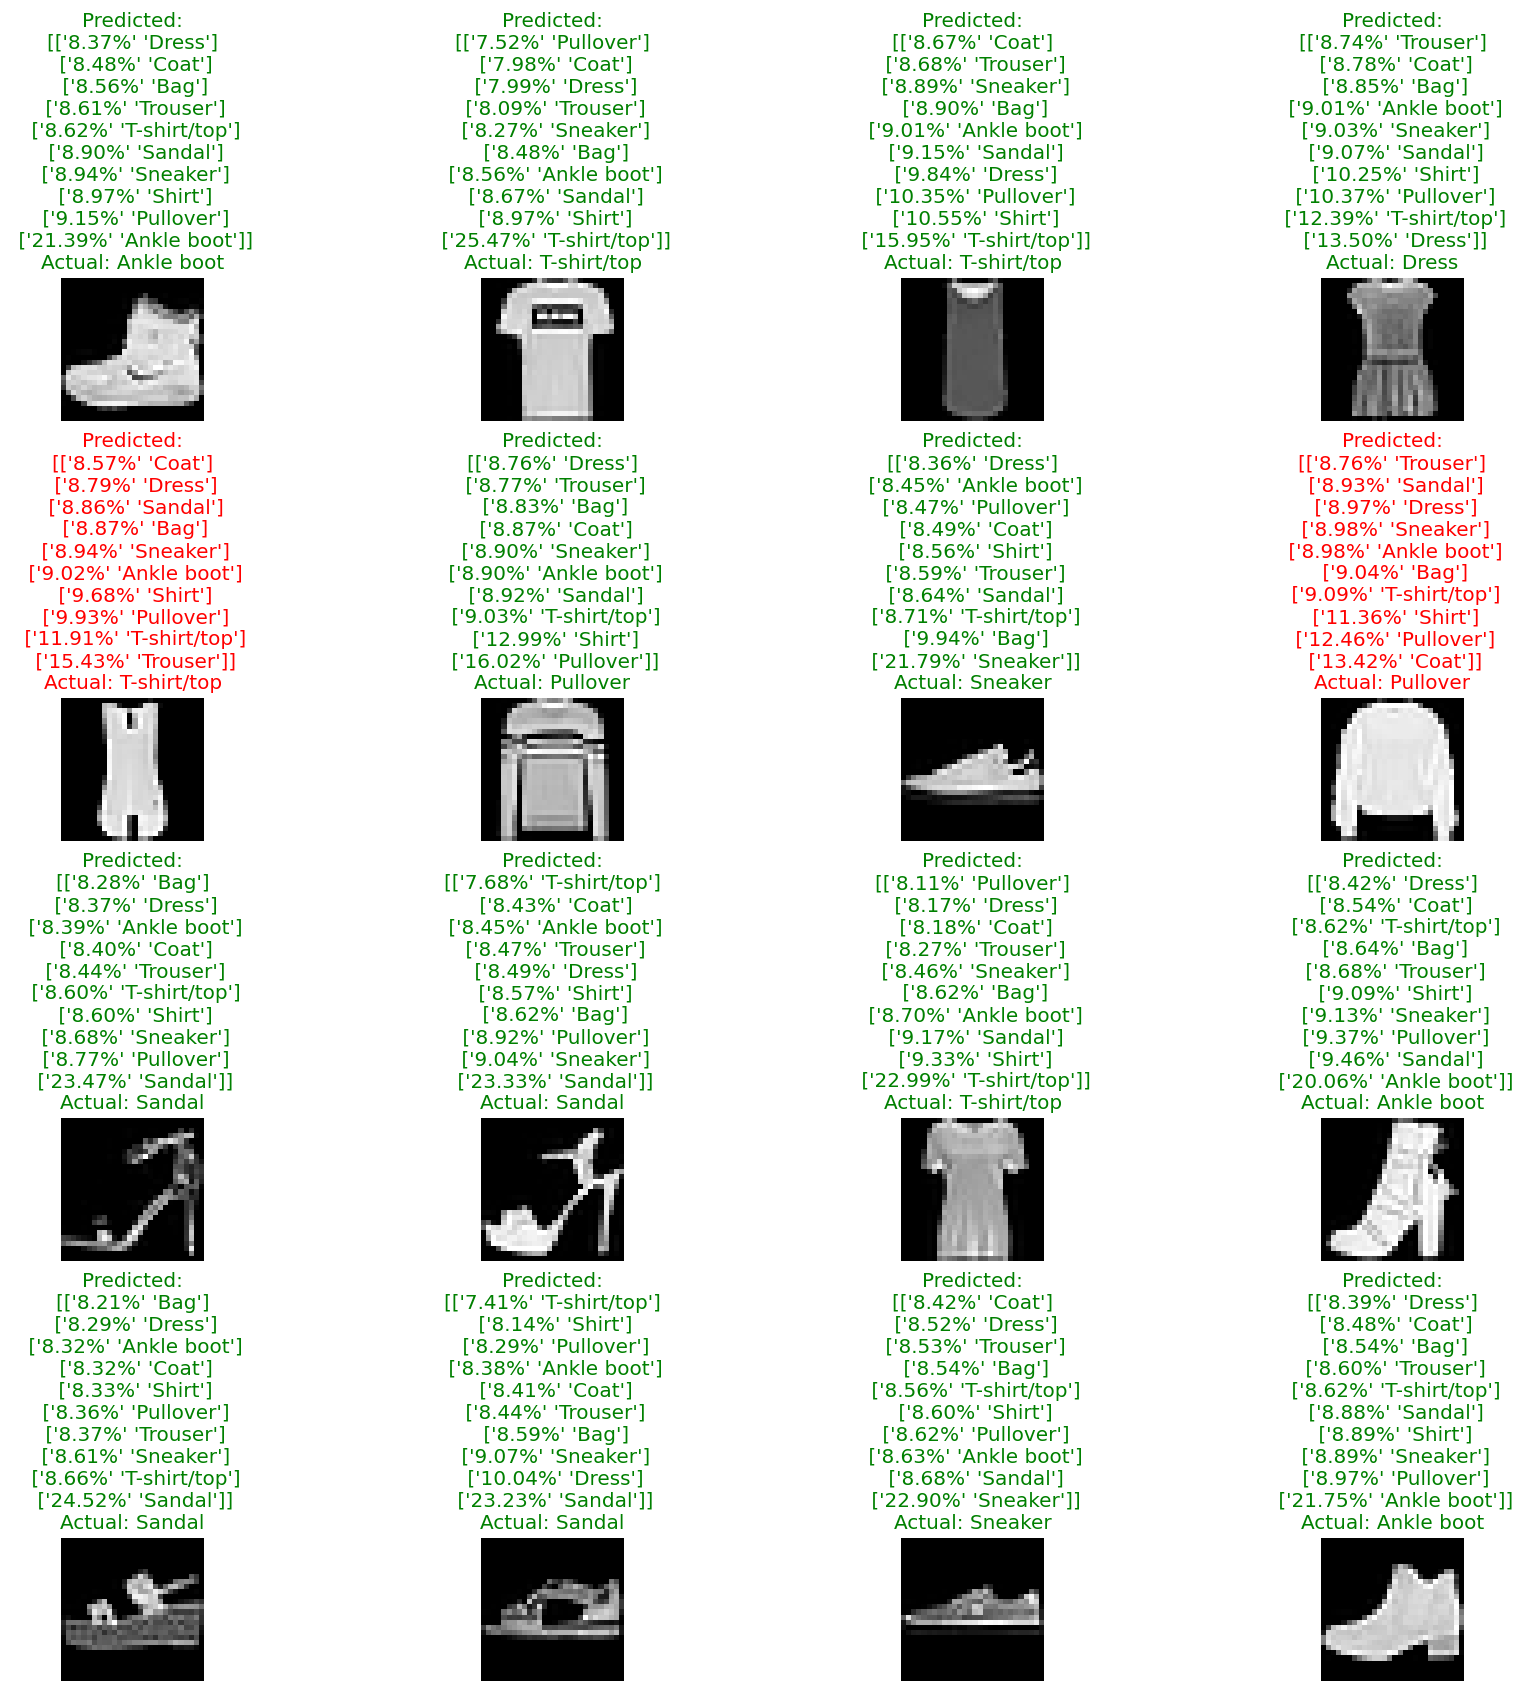

In [9]:
# Get labels and their normalized probability
def get_labels_acc(logits):
    m = nn.Softmax(dim=0)
    sm = m(logits).cpu().numpy()
    out = [(sm[i]*100, model1.labels[i]) for i in range(len(sm))]
    srtd = sorted(out)
    return srtd

# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
images, true_labels = (None, None)
for batch, (X1, y1) in enumerate(train_dl2):
    images = X1
    true_labels = y1
    break

with torch.no_grad():
    preds = model1.forward(images)

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = images[r*4+c].to("cpu")
            label_real = model1.labels[true_labels[r*4+c].to("cpu").item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions
            
            logits = preds[r*4+c].to("cpu")
            res = get_labels_acc(logits)
            res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
            label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

Great! So our model seems to be doing pretty well. I'll refer to this diagram later when we've done some knowledge distillation. Note that this model performs worse than the MLP, which might not be the case if I train for more epochs. However, I'm not going for accuracy so I'll just stick with 50 to show knowledge distillation.

Let's now define a much smaller model, with a max of 16 channels instead of 32 and an output of 8 channels, and do knowledge distillation training. Here, instead of training on the true label I'll use the first model's predictions as the "true" label during training. The below code blocks are the same as above so I won't explain them.

In [10]:
# Create our model
class NeuralNetwork2(nn.Module):
    def __init__(self):
        # See https://realpython.com/python-super/
        super(NeuralNetwork2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,padding='same')
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Linear(8 * 6 * 6, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
        )

        
        # Define labels
        self.labels = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
    def get_label(self, logits):
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        return y_pred
    
    # Get labels and their normalized probability
    def get_labels_acc(self, x):
        logits = self.forward(x)
        logits = logits
        m = nn.Softmax(dim=1)
        sm = m(logits).cpu().numpy()[0]
        out = [(sm[i]*100, self.labels[i]) for i in range(len(sm))]
        srtd = sorted(out)
        return srtd

model2 = NeuralNetwork2().to(device)

In [11]:
# Make our optimizer
loss_fn2 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

In [12]:
def train_loop2(dataloader, model_in, model_distill, loss_fn, optimizer):
    size = len(dataloader)*batch_size
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model_in(X)
        y = model_distill(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
train_acc2 = list()
test_acc2 = list()
train_loss2 = list()
test_loss2 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop2(train_dl2, model2, model1, loss_fn2, optimizer2)
    
    acc, loss = test_loop(train_dl2, model2, loss_fn2)
    train_acc2.append(acc)
    train_loss2.append(loss)
    
    acc, loss = test_loop(test_dl2, model2, loss_fn2)
    test_acc2.append(acc)
    test_loss2.append(loss)
print("Done!")

Epoch 1
---------------------------------
loss: 0.103880  [    0/60000]
loss: 0.068317  [ 3200/60000]
loss: 0.045623  [ 6400/60000]
loss: 0.042264  [ 9600/60000]
loss: 0.033009  [12800/60000]
loss: 0.032595  [16000/60000]
loss: 0.025781  [19200/60000]
loss: 0.031352  [22400/60000]
loss: 0.026050  [25600/60000]
loss: 0.029150  [28800/60000]
loss: 0.020120  [32000/60000]
loss: 0.018102  [35200/60000]
loss: 0.021882  [38400/60000]
loss: 0.015361  [41600/60000]
loss: 0.012538  [44800/60000]
loss: 0.016789  [48000/60000]
loss: 0.015428  [51200/60000]
loss: 0.014515  [54400/60000]
loss: 0.012863  [57600/60000]
Test Error: 
 Accuracy: 72.4%, Avg loss: 0.038453 

correct: 72.40833333333333%
loss :0.038452787434061365%
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.039006 

correct: 72.20447284345049%
loss :0.03900588948886615%
Epoch 2
---------------------------------
loss: 0.022588  [    0/60000]
loss: 0.012321  [ 3200/60000]
loss: 0.013073  [ 6400/60000]
loss: 0.022991  [ 9600/60000]
loss: 0.009

loss: 0.005343  [ 3200/60000]
loss: 0.007002  [ 6400/60000]
loss: 0.006715  [ 9600/60000]
loss: 0.001975  [12800/60000]
loss: 0.003873  [16000/60000]
loss: 0.003751  [19200/60000]
loss: 0.002108  [22400/60000]
loss: 0.006842  [25600/60000]
loss: 0.007500  [28800/60000]
loss: 0.002845  [32000/60000]
loss: 0.004619  [35200/60000]
loss: 0.002844  [38400/60000]
loss: 0.004099  [41600/60000]
loss: 0.004285  [44800/60000]
loss: 0.003906  [48000/60000]
loss: 0.004252  [51200/60000]
loss: 0.004087  [54400/60000]
loss: 0.001645  [57600/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.023028 

correct: 84.10499999999999%
loss :0.023028331136330963%
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.023937 

correct: 83.4764376996805%
loss :0.023937096709189132%
Epoch 12
---------------------------------
loss: 0.003664  [    0/60000]
loss: 0.005750  [ 3200/60000]
loss: 0.006941  [ 6400/60000]
loss: 0.006629  [ 9600/60000]
loss: 0.002113  [12800/60000]
loss: 0.003604  [16000/60000]
loss: 0.003467  [19200

loss: 0.003706  [ 3200/60000]
loss: 0.005872  [ 6400/60000]
loss: 0.006352  [ 9600/60000]
loss: 0.002610  [12800/60000]
loss: 0.003058  [16000/60000]
loss: 0.003245  [19200/60000]
loss: 0.001944  [22400/60000]
loss: 0.004986  [25600/60000]
loss: 0.005729  [28800/60000]
loss: 0.002656  [32000/60000]
loss: 0.003660  [35200/60000]
loss: 0.001959  [38400/60000]
loss: 0.003366  [41600/60000]
loss: 0.003317  [44800/60000]
loss: 0.003250  [48000/60000]
loss: 0.003825  [51200/60000]
loss: 0.003254  [54400/60000]
loss: 0.001053  [57600/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.022110 

correct: 84.635%
loss :0.022109887263178824%
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.023203 

correct: 83.88578274760383%
loss :0.023202651998581597%
Epoch 22
---------------------------------
loss: 0.003105  [    0/60000]
loss: 0.003828  [ 3200/60000]
loss: 0.005917  [ 6400/60000]
loss: 0.006533  [ 9600/60000]
loss: 0.002584  [12800/60000]
loss: 0.003166  [16000/60000]
loss: 0.003235  [19200/60000]
lo

loss: 0.004275  [ 3200/60000]
loss: 0.005565  [ 6400/60000]
loss: 0.005874  [ 9600/60000]
loss: 0.002279  [12800/60000]
loss: 0.002950  [16000/60000]
loss: 0.003278  [19200/60000]
loss: 0.002182  [22400/60000]
loss: 0.004315  [25600/60000]
loss: 0.005308  [28800/60000]
loss: 0.002372  [32000/60000]
loss: 0.003292  [35200/60000]
loss: 0.001832  [38400/60000]
loss: 0.002819  [41600/60000]
loss: 0.003454  [44800/60000]
loss: 0.003305  [48000/60000]
loss: 0.003043  [51200/60000]
loss: 0.002865  [54400/60000]
loss: 0.001210  [57600/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.021813 

correct: 84.80333333333333%
loss :0.021813357696806392%
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.022918 

correct: 84.0055910543131%
loss :0.022918423173574214%
Epoch 32
---------------------------------
loss: 0.003429  [    0/60000]
loss: 0.004351  [ 3200/60000]
loss: 0.005334  [ 6400/60000]
loss: 0.005725  [ 9600/60000]
loss: 0.002293  [12800/60000]
loss: 0.002861  [16000/60000]
loss: 0.003244  [19200

loss: 0.002697  [ 3200/60000]
loss: 0.005407  [ 6400/60000]
loss: 0.005319  [ 9600/60000]
loss: 0.001963  [12800/60000]
loss: 0.002742  [16000/60000]
loss: 0.003342  [19200/60000]
loss: 0.001955  [22400/60000]
loss: 0.003283  [25600/60000]
loss: 0.005247  [28800/60000]
loss: 0.002002  [32000/60000]
loss: 0.003262  [35200/60000]
loss: 0.001598  [38400/60000]
loss: 0.002609  [41600/60000]
loss: 0.003253  [44800/60000]
loss: 0.003445  [48000/60000]
loss: 0.003120  [51200/60000]
loss: 0.002610  [54400/60000]
loss: 0.001121  [57600/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.021795 

correct: 84.85166666666667%
loss :0.021794597989320756%
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.022917 

correct: 84.0055910543131%
loss :0.02291711096089488%
Epoch 42
---------------------------------
loss: 0.003363  [    0/60000]
loss: 0.003542  [ 3200/60000]
loss: 0.005332  [ 6400/60000]
loss: 0.005285  [ 9600/60000]
loss: 0.001827  [12800/60000]
loss: 0.002646  [16000/60000]
loss: 0.003584  [19200/

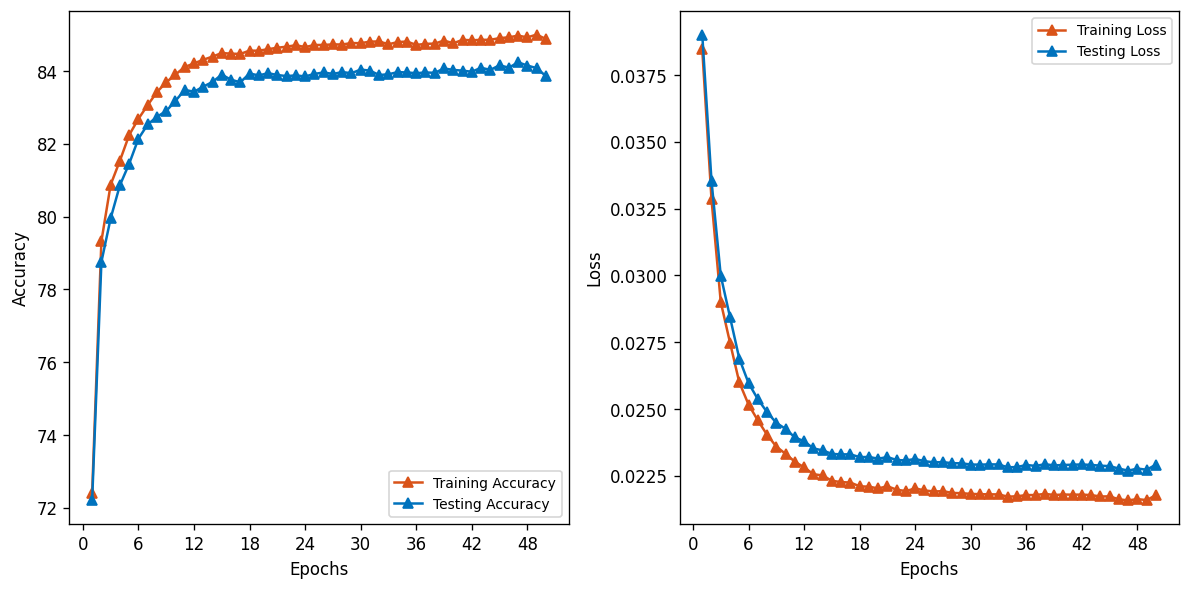

Max training accuracy: 85.00% at epoch 49
Max testing accuracy:  84.24% at epoch 47
Min training loss:     0.021581554726883768 at epoch 47
Min testing loss:      0.022692480939812364 at epoch 47


In [17]:
plot_train_test_acc_loss(train_acc2, test_acc2, train_loss2, test_loss2)
print(f"Max training accuracy: {max(train_acc2):2.2f}% at epoch {np.argmax(train_acc2)+1}")
print(f"Max testing accuracy:  {max(test_acc2):2.2f}% at epoch {np.argmax(test_acc2)+1}")
print(f"Min training loss:     {min(train_loss2)} at epoch {np.argmin(train_loss2)+1}")
print(f"Min testing loss:      {min(test_loss2)} at epoch {np.argmin(test_loss2)+1}")

Recalling the original, larger Convolutional Neural Network's results:

```
Max training accuracy: 85.94% at epoch 48
Max testing accuracy:  84.67% at epoch 48
Min training loss:     0.020391059402003885 at epoch 47
Min testing loss:      0.022229579866479953 at epoch 43
```

we see that this model performed extremely similarly. This is what we'd expect with knowledge distillation since we're training our smaller model to perform like our larger model. Let's see how the labels compare:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2393/1317591163.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


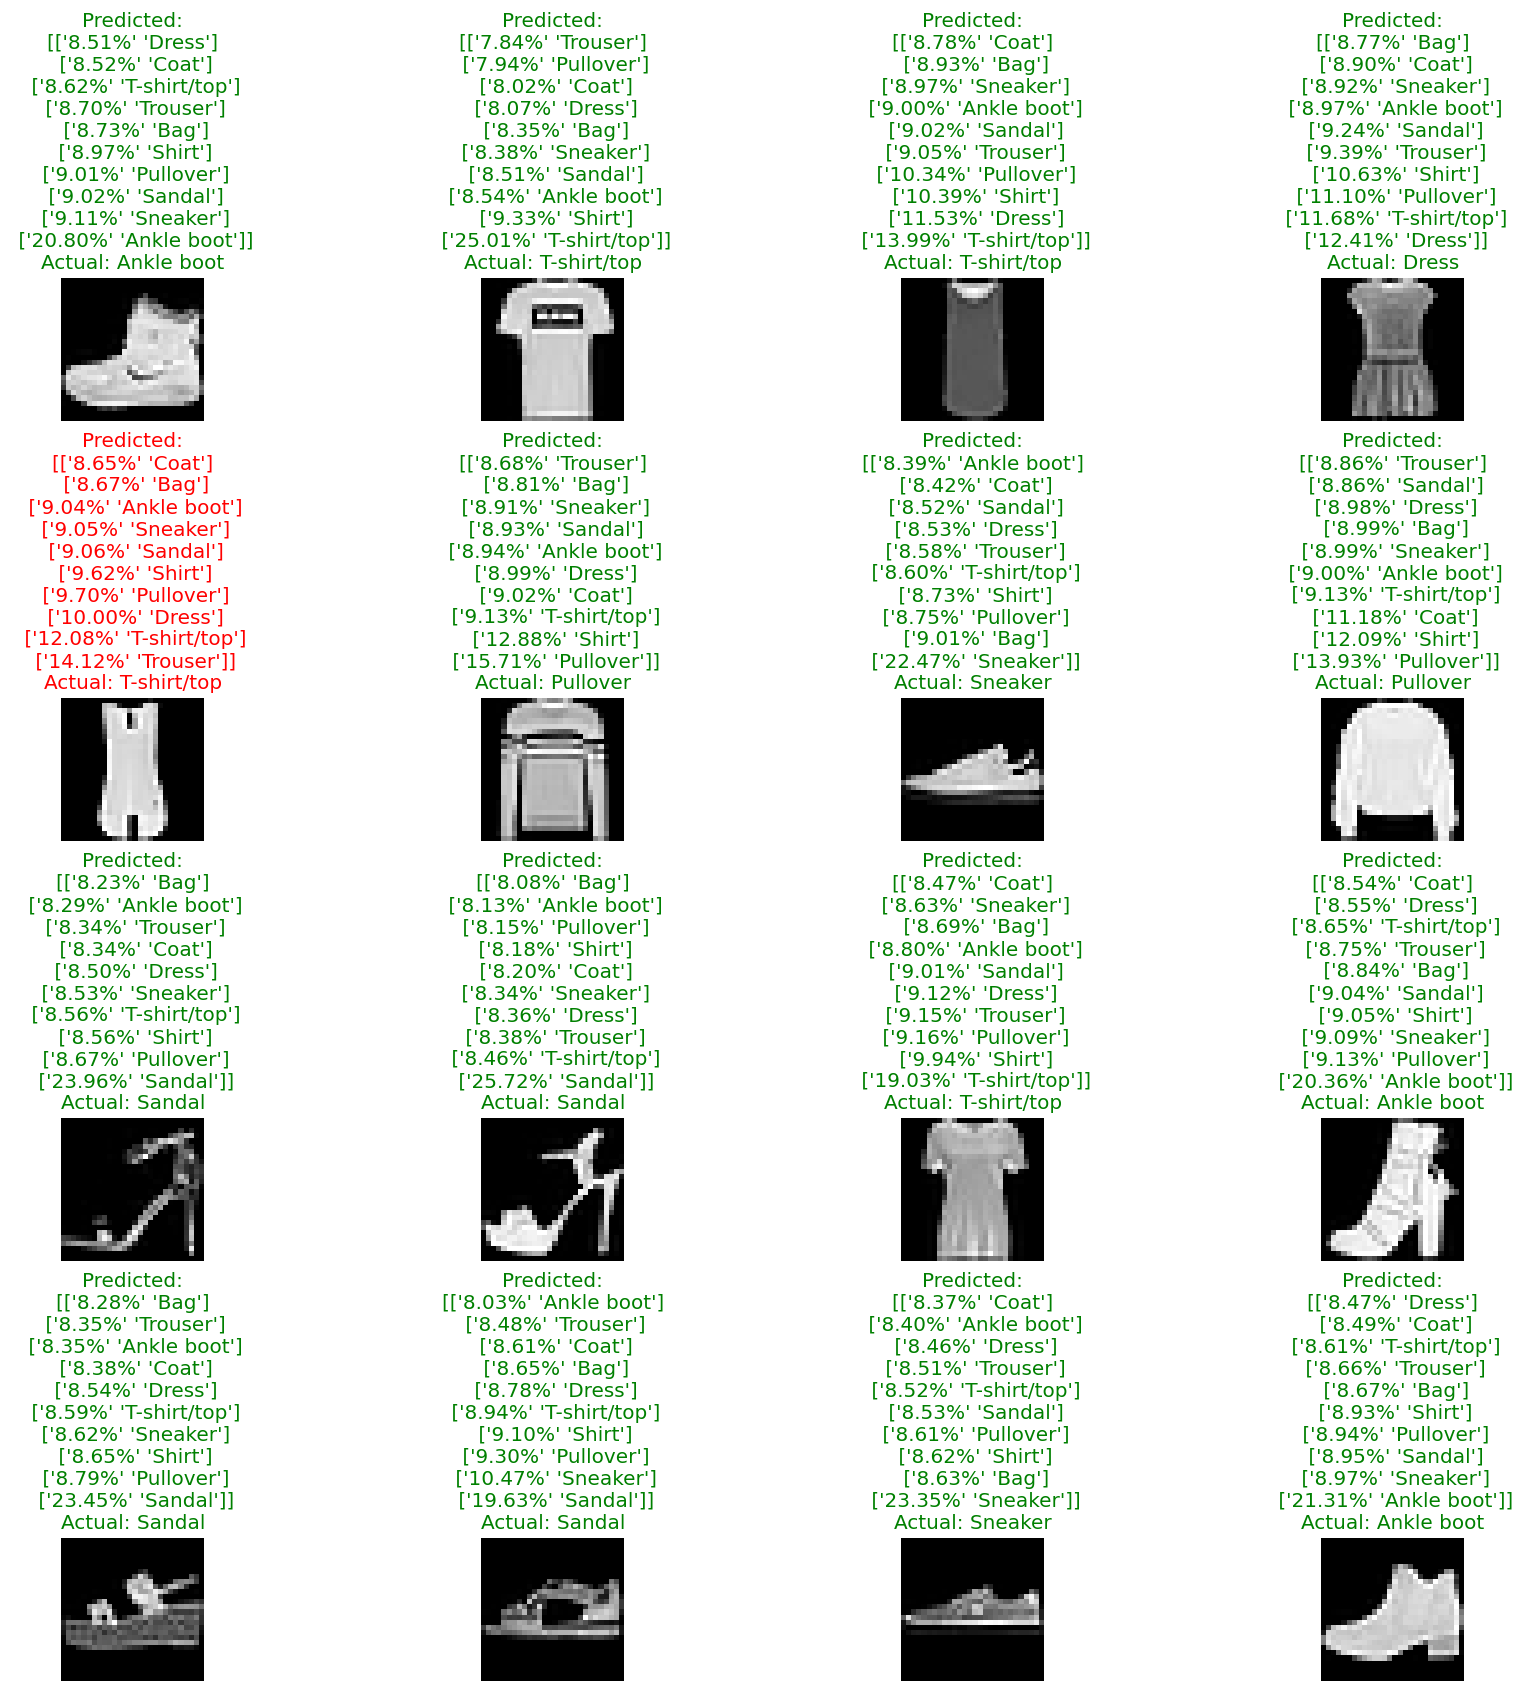

In [15]:
# Get labels and their normalized probability
def get_labels_acc(logits):
    m = nn.Softmax(dim=0)
    sm = m(logits).cpu().numpy()
    out = [(sm[i]*100, model2.labels[i]) for i in range(len(sm))]
    srtd = sorted(out)
    return srtd

# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
images, true_labels = (None, None)
for batch, (X1, y1) in enumerate(train_dl2):
    images = X1
    true_labels = y1
    break

with torch.no_grad():
    preds = model2.forward(images)

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = images[r*4+c].to("cpu")
            label_real = model2.labels[true_labels[r*4+c].to("cpu").item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions
            
            logits = preds[r*4+c].to("cpu")
            res = get_labels_acc(logits)
            res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
            label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

Fantastic! The labels match up extremely well too! So, my intuition about MLP's not working for knowledge distillation and convolutional networks working was right. Lets now train the smaller model on the original dataset without using knowledge distillation.

In [18]:
model3 = NeuralNetwork2().to(device)

In [19]:
# Make our optimizer
loss_fn3 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

In [20]:
train_acc3 = list()
test_acc3 = list()
train_loss3 = list()
test_loss3 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop(train_dl2, model3, loss_fn3, optimizer3)
    
    acc, loss = test_loop(train_dl2, model3, loss_fn3)
    train_acc3.append(acc)
    train_loss3.append(loss)
    
    acc, loss = test_loop(test_dl2, model3, loss_fn3)
    test_acc3.append(acc)
    test_loss3.append(loss)
print("Done!")

Epoch 1
---------------------------------
loss: 0.130609  [    0/60000]
loss: 0.084074  [ 3200/60000]
loss: 0.070702  [ 6400/60000]
loss: 0.066094  [ 9600/60000]
loss: 0.049805  [12800/60000]
loss: 0.057393  [16000/60000]
loss: 0.047635  [19200/60000]
loss: 0.038665  [22400/60000]
loss: 0.047298  [25600/60000]
loss: 0.054673  [28800/60000]
loss: 0.052121  [32000/60000]
loss: 0.035833  [35200/60000]
loss: 0.036912  [38400/60000]
loss: 0.053121  [41600/60000]
loss: 0.041426  [44800/60000]
loss: 0.040561  [48000/60000]
loss: 0.030057  [51200/60000]
loss: 0.040827  [54400/60000]
loss: 0.037131  [57600/60000]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.038674 

correct: 75.25833333333334%
loss :0.03867395232965549%
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.039353 

correct: 74.57068690095848%
loss :0.03935318550886437%
Epoch 2
---------------------------------
loss: 0.036312  [    0/60000]
loss: 0.034079  [ 3200/60000]
loss: 0.032820  [ 6400/60000]
loss: 0.039222  [ 9600/60000]
loss: 0.0306

loss: 0.023940  [ 3200/60000]
loss: 0.021042  [ 6400/60000]
loss: 0.020646  [ 9600/60000]
loss: 0.019068  [12800/60000]
loss: 0.023919  [16000/60000]
loss: 0.016834  [19200/60000]
loss: 0.010513  [22400/60000]
loss: 0.026052  [25600/60000]
loss: 0.027149  [28800/60000]
loss: 0.027072  [32000/60000]
loss: 0.011308  [35200/60000]
loss: 0.015963  [38400/60000]
loss: 0.025042  [41600/60000]
loss: 0.031207  [44800/60000]
loss: 0.021531  [48000/60000]
loss: 0.016825  [51200/60000]
loss: 0.021665  [54400/60000]
loss: 0.022206  [57600/60000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.019097 

correct: 88.72166666666666%
loss :0.019096635281667114%
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.020203 

correct: 87.73961661341852%
loss :0.020202961637260625%
Epoch 12
---------------------------------
loss: 0.018987  [    0/60000]
loss: 0.022809  [ 3200/60000]
loss: 0.018288  [ 6400/60000]
loss: 0.020089  [ 9600/60000]
loss: 0.016845  [12800/60000]
loss: 0.021936  [16000/60000]
loss: 0.018609  [1920

loss: 0.019103  [ 3200/60000]
loss: 0.015178  [ 6400/60000]
loss: 0.017543  [ 9600/60000]
loss: 0.008945  [12800/60000]
loss: 0.019814  [16000/60000]
loss: 0.015231  [19200/60000]
loss: 0.008837  [22400/60000]
loss: 0.023288  [25600/60000]
loss: 0.020109  [28800/60000]
loss: 0.028296  [32000/60000]
loss: 0.011736  [35200/60000]
loss: 0.016595  [38400/60000]
loss: 0.020405  [41600/60000]
loss: 0.026308  [44800/60000]
loss: 0.019354  [48000/60000]
loss: 0.012570  [51200/60000]
loss: 0.019696  [54400/60000]
loss: 0.018968  [57600/60000]
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.016452 

correct: 90.30333333333334%
loss :0.016452207079033058%
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.017923 

correct: 89.31709265175719%
loss :0.017922639955406466%
Epoch 22
---------------------------------
loss: 0.018593  [    0/60000]
loss: 0.018768  [ 3200/60000]
loss: 0.015169  [ 6400/60000]
loss: 0.016945  [ 9600/60000]
loss: 0.008812  [12800/60000]
loss: 0.020086  [16000/60000]
loss: 0.014863  [1920

loss: 0.016596  [ 3200/60000]
loss: 0.012695  [ 6400/60000]
loss: 0.016879  [ 9600/60000]
loss: 0.007212  [12800/60000]
loss: 0.020190  [16000/60000]
loss: 0.013764  [19200/60000]
loss: 0.006386  [22400/60000]
loss: 0.022695  [25600/60000]
loss: 0.019599  [28800/60000]
loss: 0.027085  [32000/60000]
loss: 0.012193  [35200/60000]
loss: 0.014707  [38400/60000]
loss: 0.019634  [41600/60000]
loss: 0.022919  [44800/60000]
loss: 0.016006  [48000/60000]
loss: 0.013631  [51200/60000]
loss: 0.018771  [54400/60000]
loss: 0.014922  [57600/60000]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.014581 

correct: 91.12166666666667%
loss :0.014581390566378832%
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.016319 

correct: 89.7064696485623%
loss :0.01631935935589476%
Epoch 32
---------------------------------
loss: 0.017816  [    0/60000]
loss: 0.015449  [ 3200/60000]
loss: 0.012664  [ 6400/60000]
loss: 0.015982  [ 9600/60000]
loss: 0.007302  [12800/60000]
loss: 0.020324  [16000/60000]
loss: 0.013695  [19200/

loss: 0.016539  [ 3200/60000]
loss: 0.012265  [ 6400/60000]
loss: 0.016204  [ 9600/60000]
loss: 0.007360  [12800/60000]
loss: 0.020427  [16000/60000]
loss: 0.013215  [19200/60000]
loss: 0.006273  [22400/60000]
loss: 0.019160  [25600/60000]
loss: 0.014671  [28800/60000]
loss: 0.025757  [32000/60000]
loss: 0.011328  [35200/60000]
loss: 0.012616  [38400/60000]
loss: 0.020526  [41600/60000]
loss: 0.019724  [44800/60000]
loss: 0.014576  [48000/60000]
loss: 0.013199  [51200/60000]
loss: 0.019192  [54400/60000]
loss: 0.013702  [57600/60000]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.013773 

correct: 91.565%
loss :0.013772780682643255%
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.015664 

correct: 90.00599041533548%
loss :0.015663845210928267%
Epoch 42
---------------------------------
loss: 0.015542  [    0/60000]
loss: 0.017555  [ 3200/60000]
loss: 0.012001  [ 6400/60000]
loss: 0.015574  [ 9600/60000]
loss: 0.007787  [12800/60000]
loss: 0.019362  [16000/60000]
loss: 0.013433  [19200/60000]
lo

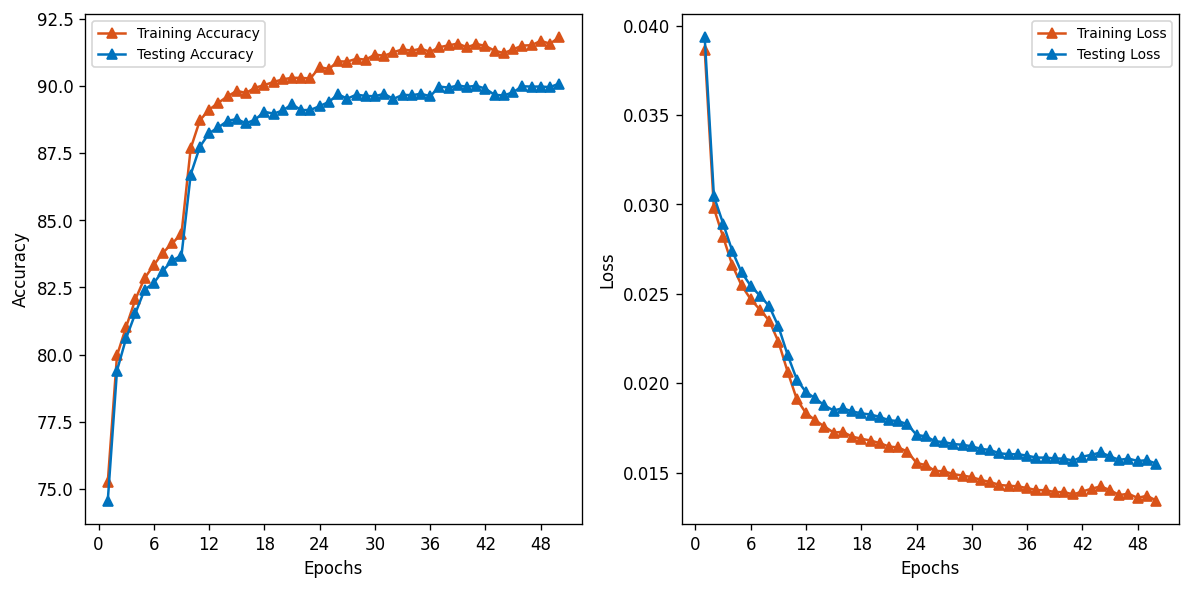

Max training accuracy: 91.81% at epoch 50
Max testing accuracy:  90.09% at epoch 50
Min training loss:     0.013432627034373581 at epoch 50
Min testing loss:      0.015499581015273071 at epoch 50


In [21]:
plot_train_test_acc_loss(train_acc3, test_acc3, train_loss3, test_loss3)
print(f"Max training accuracy: {max(train_acc3):2.2f}% at epoch {np.argmax(train_acc3)+1}")
print(f"Max testing accuracy:  {max(test_acc3):2.2f}% at epoch {np.argmax(test_acc3)+1}")
print(f"Min training loss:     {min(train_loss3)} at epoch {np.argmin(train_loss3)+1}")
print(f"Min testing loss:      {min(test_loss3)} at epoch {np.argmin(test_loss3)+1}")

Recalling the original, larger Convolutional Neural Network's results:

```
Max training accuracy: 85.94% at epoch 48
Max testing accuracy:  84.67% at epoch 48
Min training loss:     0.020391059402003885 at epoch 47
Min testing loss:      0.022229579866479953 at epoch 43
```

Recalling the knowledge-distilled results:

```
Max training accuracy: 85.00% at epoch 49
Max testing accuracy:  84.24% at epoch 47
Min training loss:     0.021581554726883768 at epoch 47
Min testing loss:      0.022692480939812364 at epoch 47
```

So, this model clearly did better without knowledge distillation. Though, I'm almost certain that training the larger model for longer would result in better accuracy and loss, which would be transferred over to the smaller, knowledge-distilled model. Unfortunately due to time constraints I wasn't able to do that here, but [the original paper](https://arxiv.org/abs/1503.02531) can be referenced for this. Let's check the labels and see how they compare to the other two models:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2393/845861993.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


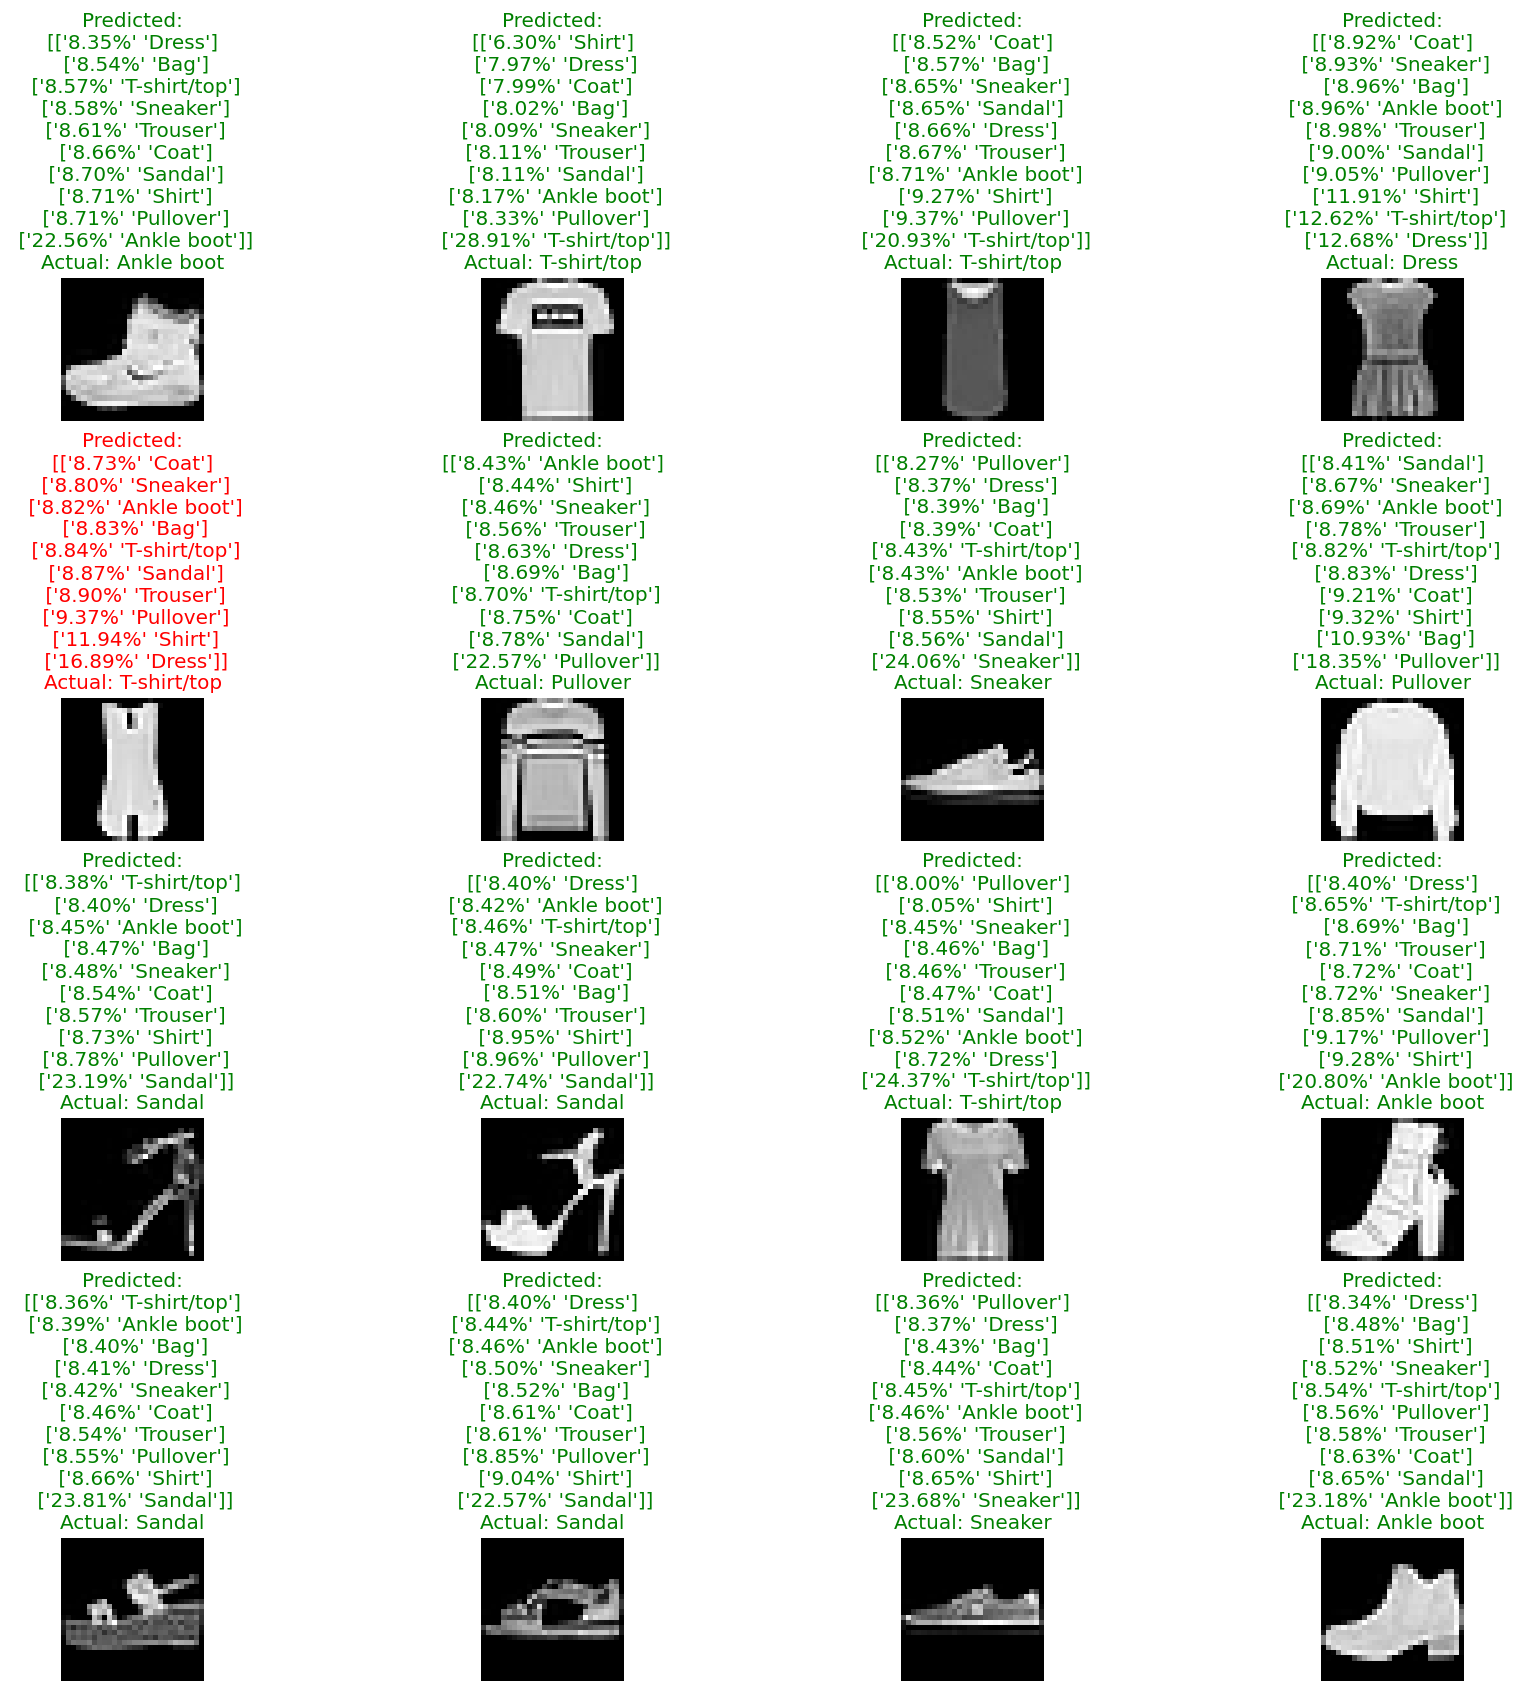

In [22]:
# Get labels and their normalized probability
def get_labels_acc(logits):
    m = nn.Softmax(dim=0)
    sm = m(logits).cpu().numpy()
    out = [(sm[i]*100, model3.labels[i]) for i in range(len(sm))]
    srtd = sorted(out)
    return srtd

# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
images, true_labels = (None, None)
for batch, (X1, y1) in enumerate(train_dl2):
    images = X1
    true_labels = y1
    break

with torch.no_grad():
    preds = model3.forward(images)

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = images[r*4+c].to("cpu")
            label_real = model3.labels[true_labels[r*4+c].to("cpu").item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions
            
            logits = preds[r*4+c].to("cpu")
            res = get_labels_acc(logits)
            res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
            label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

Excellent! The labels don't match up with the other two models, which is what we expect since no knowledge distillation happened with this model.

Overall, in this report I learned that knowledge distillation works for specific applications, like image classification in convolutional neural networks. I also learned how effective it is at transferring knowledge and how easy it is to implement. The only difference between non-knowledge distillation and knowledge distillation was the labels that were used to train the model. For further exploration I could train the larger convolutional neural network for longer to outperform the third model to show the benefits of knowledge distillation better.